In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "minst"

PATH.mkdir(parents=True, exist_ok=True)
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)


In [14]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')



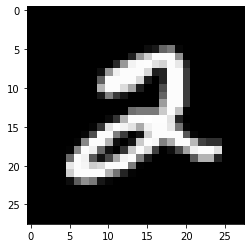

In [13]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[5].reshape((28, 28)), cmap="gray")


In [9]:
print(x_train.shape)

(50000, 784)


In [15]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape


In [11]:
x_train.shape

torch.Size([50000, 784])

In [18]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [19]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)


In [21]:
bs = 64

XB = xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-2.1059, -2.0064, -2.0603, -2.8407, -2.8436, -2.2230, -2.2260, -2.6187,
         -2.0055, -2.5764], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [26]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [34]:
YB = yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4043, grad_fn=<NegBackward>)


In [31]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [32]:
print(accuracy(preds, yb))

tensor(0.1094)


In [33]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        

In [36]:
print(loss_func(model(XB), YB), accuracy(model(XB), YB))

tensor(0.2282, grad_fn=<NegBackward>) tensor(0.9531)


In [37]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias



In [38]:
print(loss_func(model(XB), YB), accuracy(model(XB), YB))

tensor(0.2282, grad_fn=<NllLossBackward>) tensor(0.9531)


In [39]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias


In [44]:
model = Mnist_Logistic()

In [45]:
print(loss_func(model(XB), YB))

tensor(2.4421, grad_fn=<NllLossBackward>)


In [46]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

In [47]:
print(loss_func(model(XB), YB))

tensor(0.2246, grad_fn=<NllLossBackward>)


In [48]:
from torch import optim

In [49]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [51]:
model, opt = get_model()
print(loss_func(model(XB), YB))

tensor(2.3587, grad_fn=<NllLossBackward>)


In [52]:

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
fit()

In [53]:
print(loss_func(model(XB), YB))

tensor(0.2278, grad_fn=<NllLossBackward>)


In [54]:
from torch.utils.data import TensorDataset


In [62]:
TensorDataset.mro()

[torch.utils.data.dataset.TensorDataset,
 torch.utils.data.dataset.Dataset,
 object]

In [58]:
?? torch.utils.data.dataset.Dataset 

In [63]:
train_ds = TensorDataset(x_train, y_train)

In [64]:
x_train.shape

torch.Size([50000, 784])

In [68]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            xb, yb = train_ds[i * bs: i * bs + bs]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
fit()
print(loss_func(model(XB), YB))

tensor(0.2271, grad_fn=<NllLossBackward>)


In [69]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [70]:
model, opt = get_model()

def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
fit()
print(loss_func(model(XB), YB))

tensor(0.2243, grad_fn=<NllLossBackward>)


In [71]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
fit()
print(loss_func(model(XB), YB))

tensor(0.2291, grad_fn=<NllLossBackward>)


In [72]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [73]:
model, opt = get_model()

def fit():
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            valid_loss = sum(loss_func(model(xb), yb)
                             for xb, yb in valid_dl)
        
        print(epoch, valid_loss / len(valid_dl))
        
fit()


0 tensor(0.3025)
1 tensor(0.2795)


In [74]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [114]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        losses, nums = zip(
            *[loss_batch(model, loss_func, xb, yb, opt)
                 for xb, yb in train_dl]                
        )
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb)
                     for xb, yb in valid_dl]                
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, train_loss, val_loss)

In [82]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [107]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #2 'mat2'

In [115]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [116]:
%%time

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.9959399934768676 1.4384264266967774
1 1.0452902437973022 0.80487557888031
2 0.6492620362472534 0.87469080452919
3 0.5074708847999573 0.6494536604881287
4 0.4411916031742096 0.5007925837516785
5 0.3915911350631714 0.48884581896066664
6 0.3577241226673126 0.596739467048645
7 0.32865236943006515 0.3171803794026375
8 0.3085102225112915 0.2533670735478401
9 0.2892756531715393 0.40950921683311464
CPU times: user 1min 59s, sys: 2min 21s, total: 4min 21s
Wall time: 38 s


In [98]:
data = """0 1.884198247871399 1.7993913557052612
1 1.028207616996765 0.9597938510894776
2 0.6326904792022705 0.662359540939331
3 0.4660184606742859 0.5069415043830872
4 0.39378326712608336 0.3938294437289238
5 0.34074171547412874 0.39892419402599333
6 0.30934994311332703 0.26812866797447205
7 0.28931416080594063 0.2313538080573082
8 0.2715235705566406 0.2718715633392334
9 0.25853731740951535 0.3269713812470436"""
err = np.array([x.split() for x in data.split("\n")], dtype=np.float)

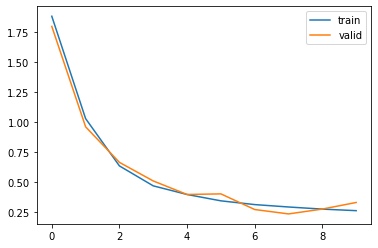

In [102]:
from matplotlib import pyplot as plt
plt.plot(err[:, [1,2]])
plt.legend(["train", "valid"])

In [117]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)


In [118]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [120]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 2
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.12744857326686382 0.11925731830894946
1 0.12481816028118134 0.11660798535943032


In [126]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


In [131]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [128]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.9560174369239807 0.44269836435317994
1 0.3523439505290985 0.23187437200546265


In [129]:
dev = torch.device("cuda")

In [132]:
model = model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.8763231941604614 0.3575656952381134
1 0.3138229029750824 0.2148989369392395
